=== Cost-Effectiveness Rate por Género y Grupo ===
  gendr variation  cost_effective
0     F   Control        0.426964
1     F      Test        0.460638
2     M   Control        0.390310
3     M      Test        0.418454

=== Análisis de Cost-Effectiveness Rate por Género ===

Género: M
   CE Rate (Test)    = 41.845%
   CE Rate (Control) = 39.031%
   z-stat = 2.9028, p-value = 0.003699
   -> Diferencia significativa (rechazamos H0).
   [Test: 2322 de 5549 clientes completaron de forma rentable]
   [Control: 1861 de 4768 clientes completaron de forma rentable]

Género: F
   CE Rate (Test)    = 46.064%
   CE Rate (Control) = 42.696%
   z-stat = 3.6493, p-value = 0.000263
   -> Diferencia significativa (rechazamos H0).
   [Test: 2873 de 6237 clientes completaron de forma rentable]
   [Control: 2315 de 5422 clientes completaron de forma rentable]



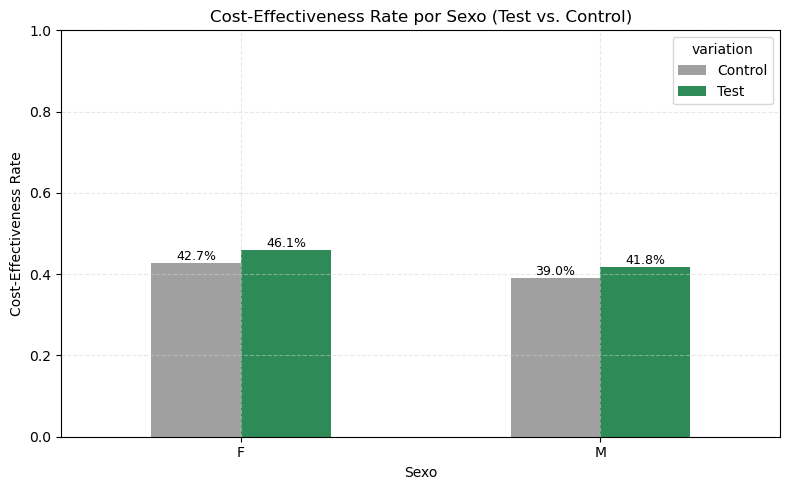

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# --------------------------------------------------
# PASO 1: Cargar el DataFrame ya procesado
# --------------------------------------------------
df = pd.read_csv("../../data/processed/navegacion_clientes_experimento_limpio.csv")

# Descartar registros con sexo desconocido
df = df[df["gendr"].isin(["M", "F"])].copy()

# --------------------------------------------------
# PASO 2: Definir si el cliente completó el proceso (llegó a 'confirm')
# --------------------------------------------------
df["completed"] = df["process_step"] == "confirm"

# --------------------------------------------------
# PASO 3: Agrupar a nivel de cliente (client_id, variation y gendr)
# --------------------------------------------------
df_clients = (
    df.groupby(["variation", "client_id"], as_index=False)
      .agg({
          "completed": "max",
          "calls_6_mnth": "first",
          "gendr": "first"
      })
)

df_clients = df_clients[df_clients["variation"].isin(["Control", "Test"])].copy()

# --------------------------------------------------
# PASO 4: Definir el umbral de coste y crear la variable "cost_effective"
# --------------------------------------------------
threshold_calls = 3
df_clients["cost_effective"] = df_clients["completed"] & (df_clients["calls_6_mnth"] <= threshold_calls)

# --------------------------------------------------
# PASO 5: Calcular el Cost-Effectiveness Rate (CE Rate) por género y grupo
# --------------------------------------------------
ce_data_gender = df_clients.groupby(["gendr", "variation"], as_index=False)["cost_effective"].mean()
print("=== Cost-Effectiveness Rate por Género y Grupo ===")
print(ce_data_gender)

# --------------------------------------------------
# PASO 6: Test de hipótesis segmentado por género
# --------------------------------------------------
def proportion_test_for_gender(seg_df):
    ce_summary = seg_df.groupby("variation")["cost_effective"].agg(["mean", "sum", "count"])
    if not {"Test", "Control"}.issubset(ce_summary.index):
        return None
    
    test_sum = ce_summary.loc["Test", "sum"]
    test_n   = ce_summary.loc["Test", "count"]
    ctrl_sum = ce_summary.loc["Control", "sum"]
    ctrl_n   = ce_summary.loc["Control", "count"]
    
    count = np.array([test_sum, ctrl_sum])
    nobs  = np.array([test_n, ctrl_n])
    stat, p_value = sm.stats.proportions_ztest(count, nobs, alternative='two-sided')
    
    return {
        "CE_Test":    ce_summary.loc["Test", "mean"],
        "CE_Control": ce_summary.loc["Control", "mean"],
        "z_stat":     stat,
        "p_value":    p_value,
        "test_sum":   test_sum,
        "test_n":     test_n,
        "ctrl_sum":   ctrl_sum,
        "ctrl_n":     ctrl_n
    }

alpha = 0.05
genders = df_clients["gendr"].unique()

print("\n=== Análisis de Cost-Effectiveness Rate por Género ===\n")
for gender in genders:
    seg_df = df_clients[df_clients["gendr"] == gender]
    result = proportion_test_for_gender(seg_df)
    if result is None:
        print(f"Género {gender}: Datos insuficientes en uno de los grupos (Test o Control).")
        continue
    print(f"Género: {gender}")
    print(f"   CE Rate (Test)    = {result['CE_Test']:.3%}")
    print(f"   CE Rate (Control) = {result['CE_Control']:.3%}")
    print(f"   z-stat = {result['z_stat']:.4f}, p-value = {result['p_value']:.6f}")
    if result["p_value"] < alpha:
        print("   -> Diferencia significativa (rechazamos H0).")
    else:
        print("   -> No hay diferencia significativa (no rechazamos H0).")
    print(f"   [Test: {int(result['test_sum'])} de {int(result['test_n'])} clientes completaron de forma rentable]")
    print(f"   [Control: {int(result['ctrl_sum'])} de {int(result['ctrl_n'])} clientes completaron de forma rentable]\n")

# --------------------------------------------------
# PASO 7: Graficar el Cost-Effectiveness Rate por Género y Grupo
# --------------------------------------------------
df_pivot = ce_data_gender.pivot(index="gendr", columns="variation", values="cost_effective")

# Definir colores corregidos: Control en gris neutro, Test en verde intenso
color_map = {"Control": "#A0A0A0", "Test": "#2E8B57", "Unknown": "gray"}
colors = [color_map.get(col, "gray") for col in df_pivot.columns]

fig, ax = plt.subplots(figsize=(8, 5))
df_pivot.plot(
    kind="bar",
    ax=ax,
    color=colors,
    legend=True
)

ax.set_title("Cost-Effectiveness Rate por Sexo (Test vs. Control)")
ax.set_xlabel("Sexo")
ax.set_ylabel("Cost-Effectiveness Rate")
ax.set_ylim(0, 1)

# Añadir rejilla con líneas discontinuas grises
ax.grid(True, which='major', axis='both', color='lightgray', linestyle='--', alpha=0.5)

# Añadir etiquetas con porcentajes en cada barra
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.annotate(f"{height:.1%}",
                    (p.get_x() + p.get_width()/2, height),
                    ha="center", va="bottom", fontsize=9)

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("../../img/ce_by_sex.jpg", dpi=300, bbox_inches='tight')
plt.show()
